In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def strat(irradiance,v_bar,c=1):
    residual = (irradiance - np.mean(irradiance))
    v = v_bar+c*residual/F
    return v

def strat_poly(irradiance,  v_bar, c,n=1):
    # c: scalar proportion
    residual = (irradiance - np.mean(irradiance))
    residual = abs(residual ** n) * np.sign(residual)
    adj = (residual) * c
    vel = v_bar - np.mean(adj) + adj
    return vel

def cal_e_dt(power,t):
    return np.trapz(power,x=t)

def cal_e_dx(power, velocity,x):
    return np.trapz(power / velocity,x=x)

def cal_drag_eout(velocity):
    return np.sum((velocity - np.mean(velocity)) ** 2)

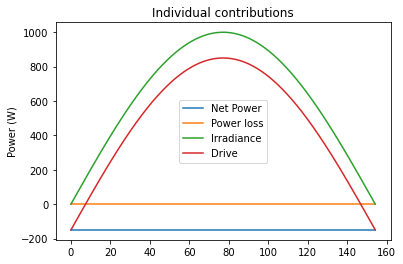

In [22]:
T = 3000/(70/3.6)
npoint = 1000
t = np.linspace(0, T, num=npoint)

### Sin irradiance distribution
I_max = 1000
irradiance = abs(I_max*np.sin(t/T*np.pi))
F = 0.5*1.225*0.108*(70/3.6)**2 # const drive force
v_bar = 70/3.6
# v_bar = np.mean(irradiance)/F

Bat_R = 0.036
V_nom = 35*3.7

v = strat(irradiance,v_bar,c=1)

P_drive = np.ones(npoint)*F*v
P_net = P_drive-irradiance
P_loss = Bat_R/V_nom**2*P_net**2

Pfig, Pax = plt.subplots(1)
Pax.set(title='Individual contributions',ylabel='Power (W)')

Pax.plot(t,P_net,label='Net Power')
Pax.plot(t,P_loss,label='Power loss')
Pax.plot(t,irradiance,label='Irradiance')
Pax.plot(t,P_drive,label='Drive')
Pax.legend()

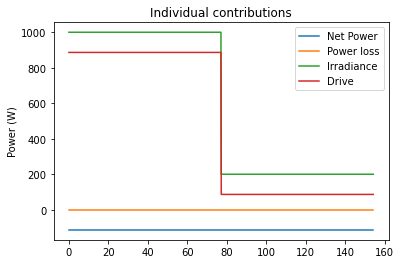

In [23]:
### stepped irradiance distribution
I_bar = 600
i = 400
npoint = 1000
irradiance = np.piecewise(t, [t < T / 2, t >= T / 2], [lambda x: I_bar + i, lambda x: I_bar - i])
v_bar = 70 / 3.6
# v_bar = np.mean(irradiance)/F

v = strat(irradiance,v_bar, 1)
v2 = strat_poly(irradiance,v_bar,1/F,1)
P_net = F*v-irradiance
P_loss = Bat_R/V_nom**2*P_net**2
P_drive = F*v

Pfig, Pax = plt.subplots(1)
Pax.set(title='Individual contributions',ylabel='Power (W)')

Pax.plot(t,P_net,label='Net Power')
Pax.plot(t,P_loss,label='Power loss')
Pax.plot(t,irradiance,label='Irradiance')
Pax.plot(t,P_drive,label='Drive')
Pax.legend()

1.0658141036401503e-14
15.151581577851333


<AxesSubplot:xlabel='Vstd', ylabel='Enet'>

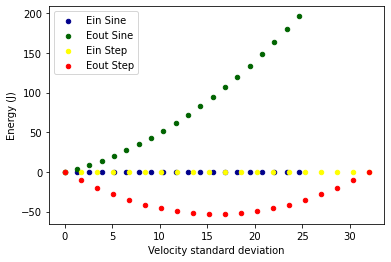

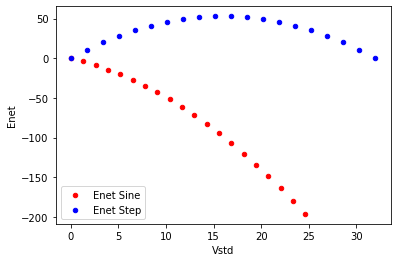

In [24]:
### Sin sweep
I_max = 1000
irradiance = abs(I_max*np.sin(t*5/T*np.pi))
F = 0.5*1.225*0.108*(70/3.6)**2 # const drive force
v_bar = 70/3.6

Bat_R = 0.036
V_nom = 35*3.7
estd=[]
for c in np.linspace(0, 2, num=20):
    v = strat(irradiance,v_bar,c=c)

    P_drive = np.ones(npoint)*F*v
    P_net = P_drive-irradiance
    P_loss = Bat_R/V_nom**2*P_net**2
    itr = [cal_e_dt(irradiance, t), cal_e_dt(P_drive+P_loss, t), np.std(v)]
    estd.append(itr)

Estdfig, estdax = plt.subplots(1)
Enetfig, enetax = plt.subplots(1)
df = pd.DataFrame(estd)
df.columns = ['Ein', 'Eout', 'Vstd']
df.loc[:, 'Eout'] = df['Eout'] - df['Eout'].iloc[0]
df.loc[:, 'Ein'] = df['Ein'] - df['Ein'].iloc[0]  # make it delta to baseline
df.plot.scatter(y="Ein", x="Vstd", color="DarkBlue", label="Ein Sine", ax=estdax)
df.plot.scatter(y="Eout", x="Vstd", color="DarkGreen", label="Eout Sine", ax=estdax)
estdax.set(xlabel='Velocity standard deviation', ylabel='Energy (J)')
df.loc[:, 'Enet'] = df['Ein'] - df['Eout']
Enetarray = df['Enet'].to_numpy()
print(maxstd := df['Vstd'].to_numpy()[np.argmax(Enetarray)])
df.plot.scatter(y='Enet', x='Vstd', ax=enetax, label="Enet Sine", color="Red")


### stepped irradiance sweep
I_bar = 600
i = 400
T = 3000/70*3.6
npoint = 1000
t = np.linspace(0, T, num=npoint)
irradiance = np.piecewise(t, [t < T / 2, t >= T / 2], [lambda x: I_bar + i, lambda x: I_bar - i])
v_bar = 70 / 3.6
# v_bar = np.mean(irradiance)/F

Bat_R = 0.036
V_nom = 35*3.7
estd=[]
for c in np.linspace(0, 2, num=20):
    v = strat(irradiance,v_bar,c=c)

    P_drive = np.ones(npoint)*F*v
    P_net = P_drive-irradiance
    P_loss = Bat_R/V_nom**2*P_net**2
    itr = [cal_e_dt(irradiance, t), cal_e_dt(P_drive+P_loss, t), np.std(v)]
    estd.append(itr)
#
# Estdfig, estdax = plt.subplots(1)
# Enetfig, enetax = plt.subplots(1)
df = pd.DataFrame(estd)
df.columns = ['Ein', 'Eout', 'Vstd']
df.loc[:, 'Eout'] = df['Eout'] - df['Eout'].iloc[0]
df.loc[:, 'Ein'] = df['Ein'] - df['Ein'].iloc[0]  # make it delta to baseline
df.plot.scatter(y="Ein", x="Vstd", color="Yellow", label="Ein Step", ax=estdax)
df.plot.scatter(y="Eout", x="Vstd", color="Red", label="Eout Step", ax=estdax)
estdax.set(xlabel='Velocity standard deviation', ylabel='Energy (J)')
df.loc[:, 'Enet'] = df['Ein'] - df['Eout']
Enetarray = df['Enet'].to_numpy()
print(maxstd := df['Vstd'].to_numpy()[np.argmax(Enetarray)])
df.plot.scatter(y='Enet', x='Vstd', ax=enetax, label="Enet Step", color="Blue")



In [25]:
### stepped irradiance distribution
I_bar = 600
i = 400
T = 2
npoint = 1000
t = np.linspace(0, T, num=npoint)
irradiance = np.piecewise(t, [t < T / 2, t >= T / 2], [lambda x: I_bar + i, lambda x: I_bar - i])
v_bar = 70 / 3.6
# v_bar = np.mean(irradiance)/F
c = 1/F
v = strat(irradiance,v_bar, 1)
v2 = strat_poly(irradiance,v_bar,c,1)
P_net = F*v-irradiance
P_loss = Bat_R/V_nom**2*P_net**2
P_drive = F*v
P_net2 = F*v_bar-irradiance
P_loss2 = Bat_R/V_nom**2*P_net2**2

cal_e_dt(P_loss,t)

0.05548933876536043

In [26]:
cal_e_dt(P_loss2,t)

0.7424200643061243

In [27]:
Bat_R/V_nom**2*cal_e_dt((F*v_bar-irradiance)**2,t)

0.7424200643061243

In [28]:
I_prime = irradiance-np.mean(irradiance)

Bat_R/V_nom**2*cal_e_dt(c*F*I_prime**2*(2-c*F),t)


0.6869307255407641

In [29]:
cal_e_dt(P_loss2,t)-cal_e_dt(P_loss,t)


0.6869307255407638

In [30]:
np.std(v)



15.993336109954187